# Part 3. Heston vs Local Volatility

In the [previous notebook](02_heston_vs_lv.ipynb) we compared prices for different exotics. Here we will keep the same dataset, and compare the distribution of forwards, to try to understand the results. 

Start with the imports.

In [ ]:
import numpy as np
import pyarrow as pa
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

from qablet_contracts.timetable import py_to_ts, TS_EVENT_SCHEMA

# models
from qablet.heston.mc import HestonMCModel
from qablet.black_scholes.mc import LVMCModel
from qablet.base.flags import Stats

## Common Dataset

In [ ]:
# Market Data
ticker = "SPX"
rate = 0.00  # 0.03
div = 0.00  # 0.01
spot = 100
pricing_dt = datetime(2023, 12, 31)

# flat array for discounts and forwards
tmax = 2.0
times = np.array([0.0, tmax])
rates = np.array([rate, rate])
fwds = spot * np.exp((rate - div) * times)

usd_crv = ("ZERO_RATES", np.column_stack((times, rates)))
fwds_crv = ("FORWARDS", np.column_stack((times, fwds)))
fwds_crv

('FORWARDS',
 array([[  0., 100.],
        [  2., 100.]]))

In [ ]:
# complete common dataset
dataset = {
    "BASE": "USD",
    "PRICING_TS": py_to_ts(pricing_dt).value,
    "ASSETS": {
        "USD": usd_crv,
        ticker: fwds_crv,
    },
    "MC": {
        "PATHS": 100_000,
        "TIMESTEP": 1 / 100,
        "SEED": 1,
        "FLAGS": Stats.CASHFLOW,
    },
}

# Heston Model and Parameters
Let us define. See here for API.

In [ ]:
heston_model = HestonMCModel()

heston_dataset = dataset.copy()
heston_dataset["HESTON"] = {
    "ASSET": ticker,
    "INITIAL_VAR": 0.04,
    "LONG_VAR": 0.04,
    "MEANREV": 10,
    "VOL_OF_VAR": 1,
    "CORRELATION": -1.0,
}

##  Local Volatility Model
We will create the Black-Scholes model object, and the dataset it requires here. Write exaplanation. "The Volatility Surface", *Chapter 4.1. Local Variance in The Heston Nandi Model.*

Modified Mean Reversion ($\lambda$) and long variance ($v$)

$$
\lambda^{'} = \lambda + \eta / 2 \\
\bar{v}^{'} = \bar{v} \cdot  \lambda / \lambda^{'}
$$

$$
v_{loc}(x_T, T) = (v-\bar{v}^{'} ) \cdot e^{-\lambda^{'} T} + \bar{v}^{'}  - \eta x_T \left\{ \frac{1 - e^{-\lambda^{'} T}}{\lambda^{'} T} \right\}
$$


In [ ]:
lv_model = LVMCModel()

# An approximation of the local vol, when correlation is -1
lm = heston_dataset["HESTON"]["MEANREV"]
eta = heston_dataset["HESTON"]["VOL_OF_VAR"]
vl = heston_dataset["HESTON"]["LONG_VAR"]
vi = heston_dataset["HESTON"]["INITIAL_VAR"]

_lm = lm + eta / 2
_vl = vl * lm / _lm


# local vol function, takes a tuple of current time and log-spot vector
def local_vol(points):
    (t, x_vec) = points

    atm = (vi - _vl) * np.exp(-_lm * t) + _vl
    if t < 1e-6:
        shape = -eta  # special case for t=0 so that denom doesn't blow up
    else:
        shape = -eta * (1 - np.exp(-_lm * t)) / (_lm * t)

    out = x_vec * shape
    np.add(out, atm, out=out)
    # floor it, because the approximation works less well away from atm and can be negative
    np.maximum(0.001, out, out=out)
    np.sqrt(out, out=out)
    return out


lv_dataset = dataset.copy()
lv_dataset["LV"] = {"ASSET": ticker, "VOL": local_vol}

## A Contract that pays every month
We will use this contract to get various cashflow statistics for the model.

In [ ]:
# array of 12 months, starting with pricing date, ending with 1 year
mns = pd.bdate_range(pricing_dt, periods=13, freq="1ME")

events = [
    {
        "track": "",
        "time": m,
        "op": "+",
        "quantity": 1,
        "unit": ticker,
    }
    for m in mns
]

events_table = pa.RecordBatch.from_pylist(events, schema=TS_EVENT_SCHEMA)
fwd_timetable = {"events": events_table, "expressions": {}}
print(fwd_timetable["events"].to_pandas())

   track                      time op  quantity unit
0        2023-12-31 00:00:00+00:00  +       1.0  SPX
1        2024-01-31 00:00:00+00:00  +       1.0  SPX
2        2024-02-29 00:00:00+00:00  +       1.0  SPX
3        2024-03-31 00:00:00+00:00  +       1.0  SPX
4        2024-04-30 00:00:00+00:00  +       1.0  SPX
5        2024-05-31 00:00:00+00:00  +       1.0  SPX
6        2024-06-30 00:00:00+00:00  +       1.0  SPX
7        2024-07-31 00:00:00+00:00  +       1.0  SPX
8        2024-08-31 00:00:00+00:00  +       1.0  SPX
9        2024-09-30 00:00:00+00:00  +       1.0  SPX
10       2024-10-31 00:00:00+00:00  +       1.0  SPX
11       2024-11-30 00:00:00+00:00  +       1.0  SPX
12       2024-12-31 00:00:00+00:00  +       1.0  SPX


In [ ]:
heston_price, heston_stats = heston_model.price(fwd_timetable, heston_dataset)
bs_price, bs_stats = lv_model.price(fwd_timetable, lv_dataset)
print(f"BS: {bs_price: 8.2f} Heston: {heston_price: 8.2f}")

BS:  1299.66 Heston:  1299.98


### Terminal Distributions
Plot the cashflow from the 12th event. Compare it with the distribution seen in Note 01 with flat volatility. Here they match.

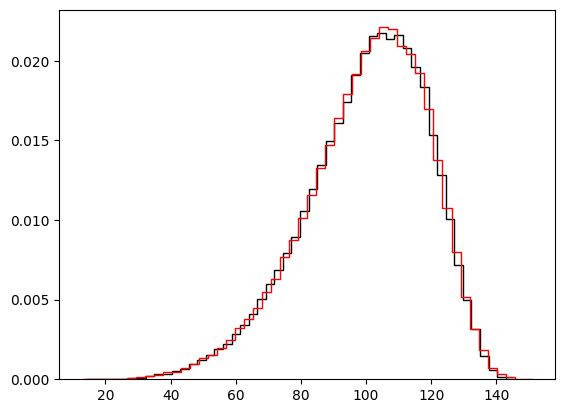

In [ ]:
ev_idx = 12  # Distribution of cashflows at given event index
for color, stats in zip(["black", "red"], [bs_stats, heston_stats]):
    plt.hist(
        stats["CASHFLOW"][0][ev_idx],
        bins=50,
        color=color,
        histtype="step",
        density=True,
    )

### Forward Distributions
Compare the cashflow distribution of
 - 11th month
 - 12th month
 - difference between the two.

Text(0, 0.5, '12 - 11 month')

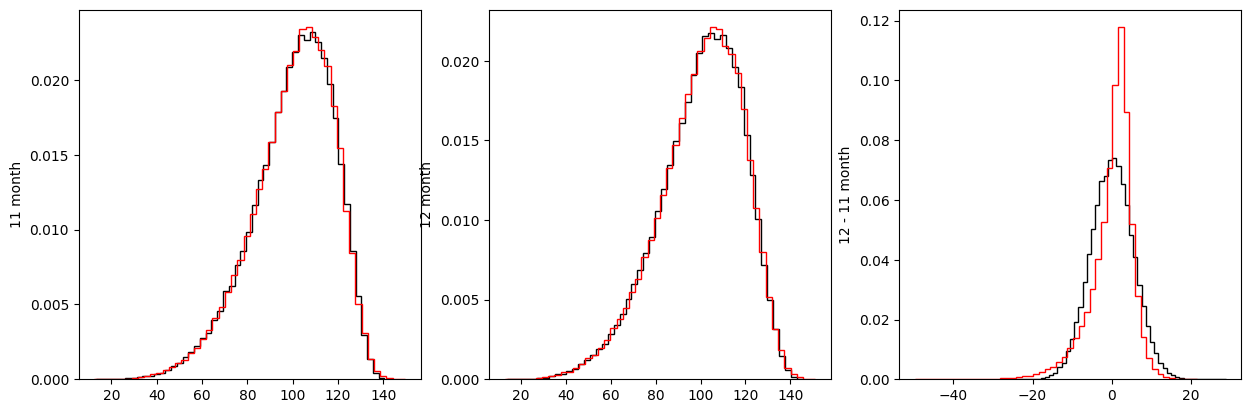

In [ ]:
# matplotlib scatter plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(15)
idx1, idx2 = 11, 12

# print(bins)
for color, stats in zip(["black", "red"], [bs_stats, heston_stats]):
    cf = stats["CASHFLOW"][0]

    ax1.hist(cf[idx1], color=color, density=True, bins=50, histtype="step")
    ax2.hist(cf[idx2], color=color, density=True, bins=50, histtype="step")
    ax3.hist(
        cf[idx2] - cf[idx1],
        color=color,
        density=True,
        bins=50,
        histtype="step",
    )

ax1.set_ylabel(f"{idx1} month")
ax2.set_ylabel(f"{idx2} month")
ax3.set_ylabel(f"{idx2} - {idx1} month")

Some Additional Plots

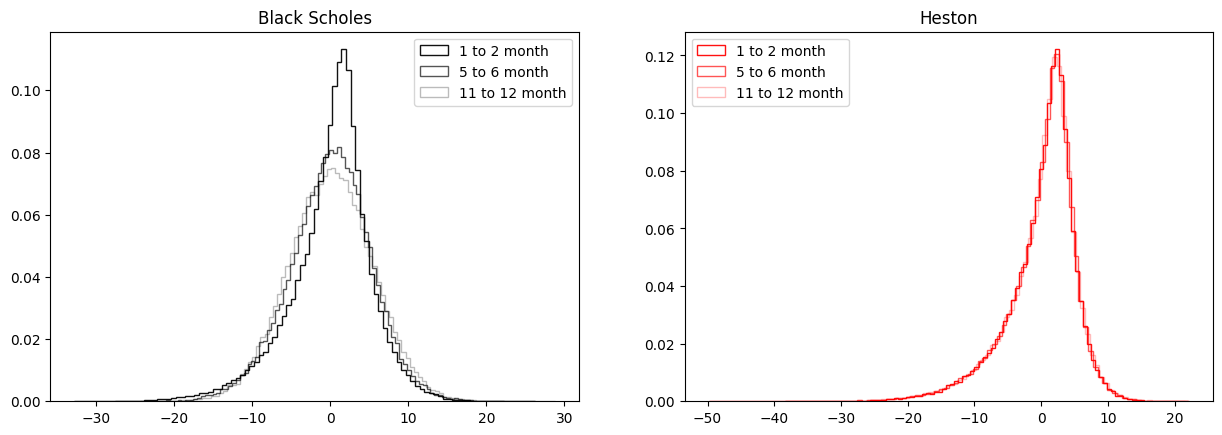

In [ ]:
# matplotlib scatter plot
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)

for color, ax, stats in zip(
    ["black", "red"], [ax1, ax2], [bs_stats, heston_stats]
):
    cf = stats["CASHFLOW"][0]

    for i in [1, 5, 11]:  # for 3 maturities
        ax.hist(
            cf[i + 1]
            - cf[i],  # difference in stock price between two successive months
            color=(color, 1 - i / 15),
            density=True,
            bins=100,
            histtype="step",
            label=f"{i} to {i+1} month",
        )

ax1.set_title("Black Scholes")
ax2.set_title("Heston")
ax1.legend()
ax2.legend()

Text(0.5, 1.0, 'Heston')

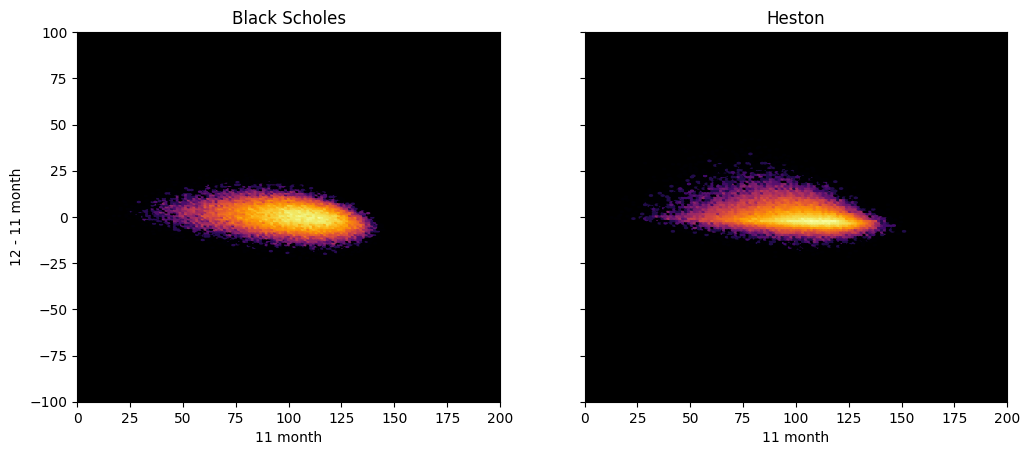

In [ ]:
# Distribution of cashflow changes
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_figwidth(12)
idx1 = 11
idx2 = 12

for ax, stats in zip([ax1, ax2], [bs_stats, heston_stats]):
    cf = stats["CASHFLOW"][0]
    f0 = cf[idx2]
    f1 = cf[idx1]

    ax.set_facecolor("black")
    b = ax.hexbin(f0, f1 - f0, bins="log", cmap="inferno")

    ax.set_xlabel(f"{idx1} month")
    ax.set_ylim(-100, 100)
    ax.set_xlim(0, 200)
ax1.set_ylabel(f"{idx2} - {idx1} month")
ax1.set_title("Black Scholes")
ax2.set_title("Heston")

Text(0.5, 1.0, 'Strike > 105%')

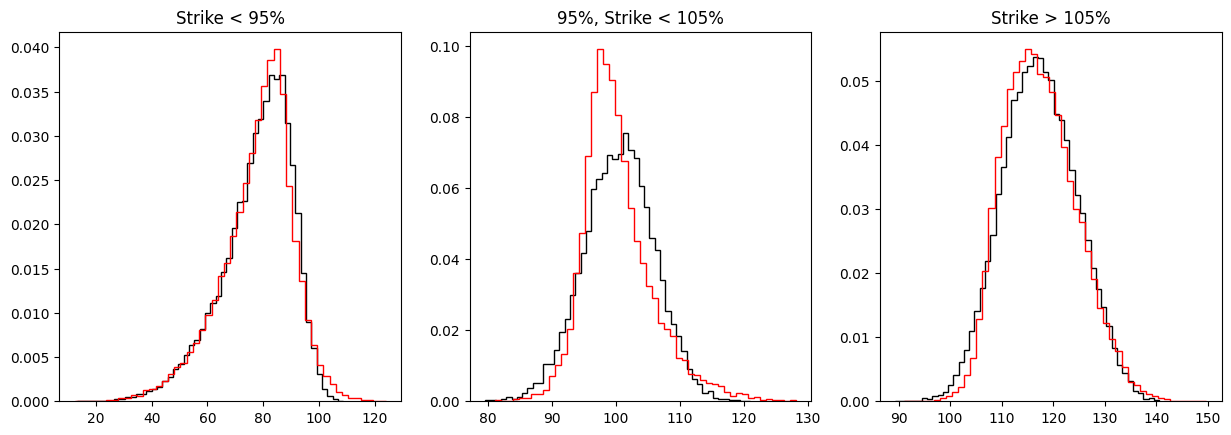

In [ ]:
# matplotlib scatter plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(15)
idx1 = 11
idx2 = 12

# print(bins)
for color, stats in zip(["black", "red"], [bs_stats, heston_stats]):
    cf = stats["CASHFLOW"][0]
    f0 = cf[idx2]
    f1 = cf[idx1]

    mask_lo = f0 < 90
    mask_mi = (f0 > 98) & (f0 < 102)
    mask_hi = f0 > 110

    ax1.hist(f1[mask_lo], color=color, density=True, bins=50, histtype="step")
    ax2.hist(f1[mask_mi], color=color, density=True, bins=50, histtype="step")
    ax3.hist(f1[mask_hi], color=color, density=True, bins=50, histtype="step")

ax1.set_title("Strike < 95%")
ax2.set_title("95%, Strike < 105%")
ax3.set_title("Strike > 105%")